In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.5.0
GPU detected: []


In [2]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(5)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [3]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [5]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [6]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [8]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [9]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [10]:
word2idx

{'discomfort': 1,
 'parents': 2,
 'deport': 3,
 'cross-strait': 4,
 'Jim': 5,
 'jump-start': 6,
 'attached': 7,
 'investigation': 8,
 'MInister': 9,
 'Taifi': 10,
 'Mainland': 11,
 'median': 12,
 'fiercer': 13,
 'enroute': 14,
 'Yi': 15,
 'prehistoric': 16,
 'hauls': 17,
 'garrison': 18,
 '1,32,000': 19,
 'export-driven': 20,
 'Valparaiso': 21,
 'contingency': 22,
 'dangers': 23,
 'Lebanon': 24,
 'Shakes': 25,
 'Clinton': 26,
 'repeated': 27,
 'Sevilla': 28,
 'current': 29,
 'inbalance': 30,
 'notes': 31,
 'post-genocide': 32,
 '261': 33,
 'Half': 34,
 'feud': 35,
 'Shots': 36,
 'stemming': 37,
 'Altria': 38,
 '3,04,569': 39,
 'assumption': 40,
 'Blueberry': 41,
 'purports': 42,
 'regrettable': 43,
 'box': 44,
 'jaws': 45,
 'Khabarovsk': 46,
 'Bank': 47,
 'Balkenende': 48,
 'Computer': 49,
 '216': 50,
 '21-month-old': 51,
 'Paulino': 52,
 'voluntarily': 53,
 'Industrial': 54,
 'discriminated': 55,
 '207.5': 56,
 'dues': 57,
 'apiece': 58,
 'Las': 59,
 'Yair': 60,
 'coffin': 61,
 'dippe

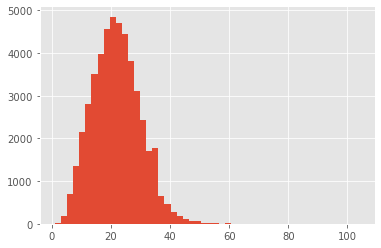

In [11]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [15]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [18]:
!pip install livelossplot

  Using cached livelossplot-0.5.5-py3-none-any.whl (22 kB)
You should consider upgrading via the '/Users/ahmadfathanhidayatullah/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

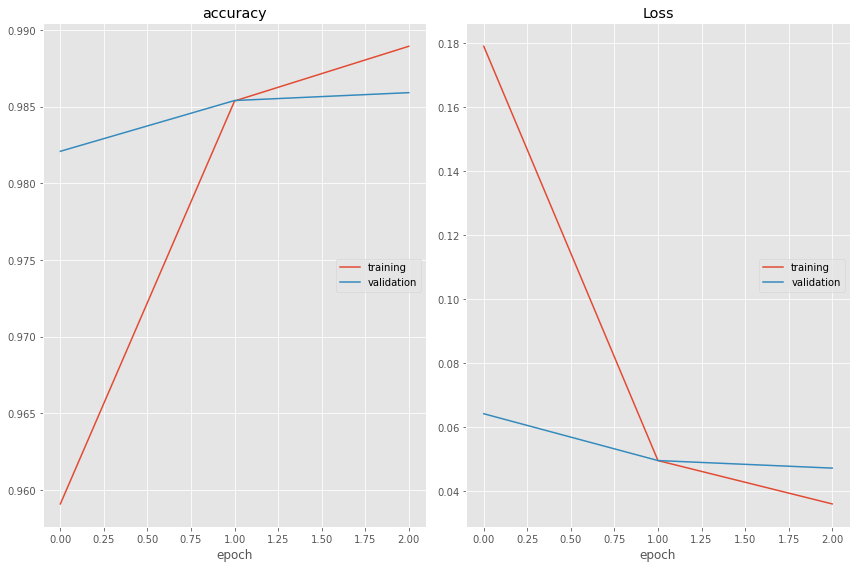

accuracy
	training         	 (min:    0.959, max:    0.989, cur:    0.989)
	validation       	 (min:    0.982, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.036, max:    0.179, cur:    0.036)
	validation       	 (min:    0.047, max:    0.064, cur:    0.047)

Epoch 00003: val_loss improved from 0.04946 to 0.04710, saving model to model_weights.h5
CPU times: user 17min 49s, sys: 6min 14s, total: 24min 4s
Wall time: 4min 40s


In [20]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

In [21]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 3s 11ms/step - loss: 0.0471 - accuracy: 0.9859


[0.047103457152843475, 0.9859028458595276]

In [22]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            O	O
United         B-org	B-org
Nations        I-org	I-org
has            O	O
been           O	O
under          O	O
fire           O	O
for            O	O
failing        O	O
to             O	O
stop           O	O
ongoing        O	O
ethnic         O	O
violence       O	O
in             O	O
Ituri          B-geo	B-geo
.              O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsidiary     O	O
subsi